In [155]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # disable protection against decompression bomb DOS attacks
import scipy.misc
import tqdm

import sys
sys.path.append("../")
import savewally

from importlib import reload

import pickle

In [144]:
df = pd.read_csv("../data/Linga Holm_ORKlh_2016_3&4_20180906.csv")
df.head()

,image_file,class,x,y,date_counted
0,StitchMICE_ORKlh16_3_1104_CP_FINAL.tif,whitecoat,1511,35752,24/05/2018
1,StitchMICE_ORKlh16_3_1104_CP_FINAL.tif,whitecoat,1535,35432,24/05/2018
2,StitchMICE_ORKlh16_3_1104_CP_FINAL.tif,whitecoat,1587,34943,24/05/2018
3,StitchMICE_ORKlh16_3_1104_CP_FINAL.tif,whitecoat,1658,35188,24/05/2018
4,StitchMICE_ORKlh16_3_1104_CP_FINAL.tif,whitecoat,1621,34248,24/05/2018


In [145]:
df.image_file.unique()

array(['StitchMICE_ORKlh16_3_1104_CP_FINAL.tif',
       'StitchMICE_ORKlh16_4_1117_CP_FINAL.tif'], dtype=object)

In [6]:
img_fn = df.image_file.unique()[1]
img_fp = "../data/" + img_fn

In [7]:
img = np.asarray(Image.open(img_fp))
print("shape:", img.shape)
print("ymax:", df.y.max())
print("xmax:", df.x.max())

In [12]:
dx, dy = 25, 25
patch_fp = "../data/patches/" + img_fn + "/positive/"

In [19]:
def generate_positive_patches(df, img, img_fn, dx=25, dy=25):
    for i, seal in df[df.image_file == img_fn].iterrows():
        patch_fp = "../data/patches/" + img_fn + "/positive/"
        patch = img[::-1,:,:][seal.y - dy:seal.y + dy,seal.x - dx:seal.x + dx]
        scipy.misc.toimage(patch, cmin=0.0, cmax=...).save(patch_fp + str(i) +'.png')

In [20]:
generate_positive_patches(df, img, img_fn)

C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """


In [21]:
from scipy.spatial.distance import cdist, pdist

In [195]:
# load trained gmm to identify grass
gmm = pickle.load( open("../gmm.p", "rb"))

In [229]:
def generate_negative_patches(n, df, img, img_fn, dx=25, dy=25, save=True, 
                              white_threshold=0.8, gmm=gmm):
    min_distance = np.sqrt(dx**2 + dy**2)
    patches_count = 0
    patch_fp = "../data/patches/" + img_fn + "/negative/"
    
    while patches_count < n:
        x = np.random.choice(img.shape[1])
        y = np.random.choice(img.shape[0])
        # check seal vicinity
        seal_distances = cdist([[x,y]], df[df.image_file == img_fn][["x", "y"]].values)
        if np.count_nonzero(min_distance > seal_distances):
            continue
        
        patch = img[::-1,:,:][y - dy:y + dy,x - dx:x + dx]
        # print(patch.shape)
        if np.mean(patch) / 255 >= white_threshold:
            continue
        
        try:
            prediction = gmm.predict(np.average(patch, axis=(0,1))[np.newaxis,:])[0]
        except ValueError:
            continue
        # print(prediction)
        if prediction == 0:
            if np.random.rand() > 0.05:
                # print(patches_count, prediction, "Rejected")
                continue
            # print(patches_count, prediction, "Accepted")
            
        if save:
            try:
                scipy.misc.toimage(patch, cmin=0.0, cmax=...).save(patch_fp + str(patches_count) +'.png')
            except ValueError:
                continue
        patches_count += 1

In [224]:
import warnings

In [ ]:
warnings.simplefilter("ignore")  # ignore warnings due to deprecated image save of scipy
generate_negative_patches(48000, df, img, img_fn, save=True, gmm=gmm)

# Unsupervised ML on negative patches to identify grass

How to get less grass taining images? Maybe cluster negative data and try to find a class cluster, train model on it (GMM?), then predict each randomly generated negative patch, if predicted as grass -> accept with low probability only, resample

how about dimensionality reduction? maybe take rgb average of subsets of image, as grass should be quite distinct from rock

In [24]:
grass = [9899, 9900, 9901, 9903, 9904, 9919]
rock = [9995, 9999, 9993, 10049, 10039, 10115]

In [30]:
grass_img = []
rock_img = []

fp = "../data/patches/" + img_fn + "/negative/"

for g in grass:
    grass_img.append(plt.imread(fp + str(g) + ".png"))
    
for r in rock:
    rock_img.append(plt.imread(fp + str(r) + ".png"))
    
grass_img = np.array(grass_img)
rock_img = np.array(rock_img)

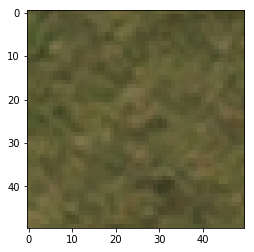

In [33]:
plt.imshow(grass_img[0,:])

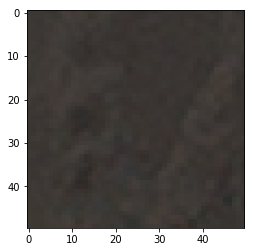

In [34]:
plt.imshow(rock_img[0,:])

In [61]:
grass_avrg = np.average(grass_img, axis=(1,2))
rock_avrg = np.average(rock_img, axis=(1,2))

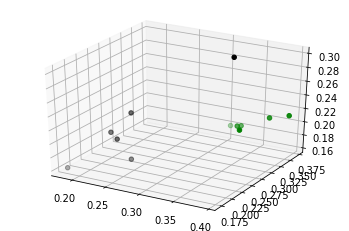

In [64]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d") # 3D plot with scalar values in each axis

ax.scatter(grass_avrg[:,0], grass_avrg[:,1], grass_avrg[:,2], color="green")
ax.scatter(rock_avrg[:,0], rock_avrg[:,1], rock_avrg[:,2], color="black")


In [76]:
reload(savewally)

<module 'savewally' from '..\\savewally\\__init__.py'>

In [78]:
fp_neg = "../data/patches/StitchMICE_ORKlh16_3_1104_CP_FINAL.tif/negative/"
negative_patches = savewally.read_patches(fp_neg, step=10)

100%|███████████████| 4800/4800 [00:01<00:00, 3153.75it/s]


In [79]:
negative_patches.shape

(4800, 50, 50, 3)

In [81]:
negpatch_avrg = np.average(negative_patches, axis=(1,2))
negpatch_avrg.shape

(4800, 3)

In [82]:
import pandas as pd

In [85]:
df = pd.DataFrame(negpatch_avrg, columns="r g b".split())

In [89]:
import sklearn.cluster

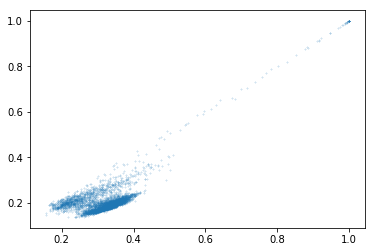

In [94]:
plt.scatter(df.r, df.b, marker="x", s=1, alpha=0.2)

In [95]:
from sklearn.manifold import TSNE


In [98]:
model = TSNE(learning_rate=100)
transformed = model.fit_transform(df.values)

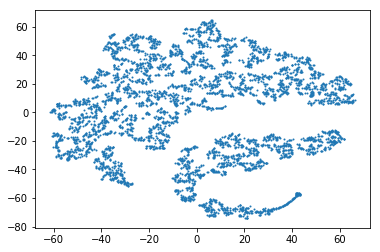

In [102]:
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]
plt.scatter(x_axis, y_axis, s=1)

In [105]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN()
dbscan.fit(transformed)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

In [127]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3)
gmm.fit(df.values)
prediction = gmm.predict(df.values)

(0.1, 0.4)

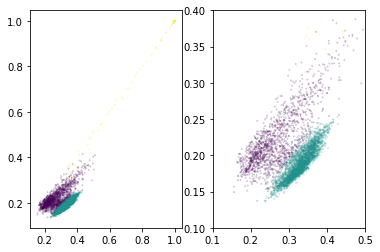

In [128]:
fig,ax = plt.subplots(ncols=2)

ax[0].scatter(df.r, df.b, marker="x", s=1, alpha=0.2, c=prediction)

ax[1].scatter(df.r, df.b, marker="x", s=1, alpha=0.2, c=prediction)
ax[1].set_xlim(0.1,0.5)
ax[1].set_ylim(0.1,0.4)

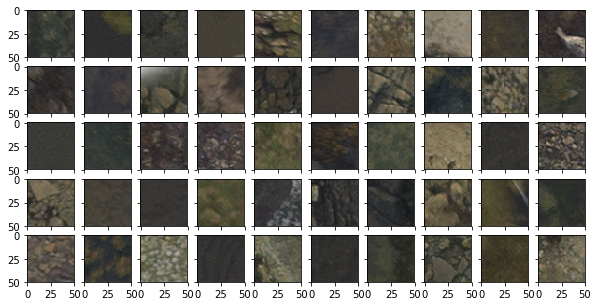

In [136]:
# randomly select from clusters and plot image
n = 50
label = 0

indices = np.random.choice(np.argwhere(prediction == label).flatten(), size=n)

fig, axes = plt.subplots(ncols=10,nrows=5, sharex=True, sharey=True, figsize=(10,5))
for ax, i in zip(axes.flat, indices):
    ax.imshow(negative_patches[i])

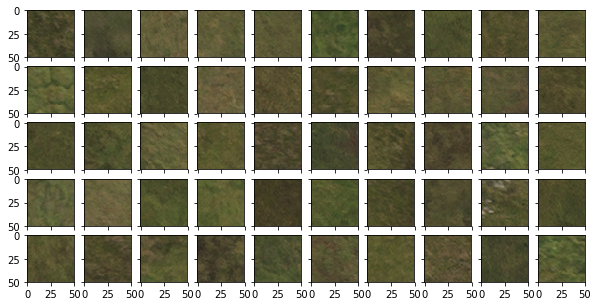

In [137]:
# randomly select from clusters and plot image
n = 50
label = 1

indices = np.random.choice(np.argwhere(prediction == label).flatten(), size=n)

fig, axes = plt.subplots(ncols=10,nrows=5, sharex=True, sharey=True, figsize=(10,5))
for ax, i in zip(axes.flat, indices):
    ax.imshow(negative_patches[i])

0.9678426
0.38461438
0.9820843
0.9999953
0.9883822
0.99991375
0.35160264
0.37520525
0.36029074
0.87653697
0.9872596
0.85046065
0.9988303
0.9803477
0.7704036
0.99923086
0.6317878
0.50499034
0.911085
0.99923086
0.9988303
0.41933647
0.3248507
0.7704036
0.99991375
0.36074513
0.6995896
0.91616887
0.82520103
0.40487272
0.55253595
0.50049675
0.46147192
0.40487272
0.9883822
0.9872596
0.75814533
0.9993997
0.59094745
0.6040795
0.48476234
0.37520525
0.6317878
0.99923086
0.50499034
0.87653697
0.50499034
0.37720683
0.97460026
0.41933647


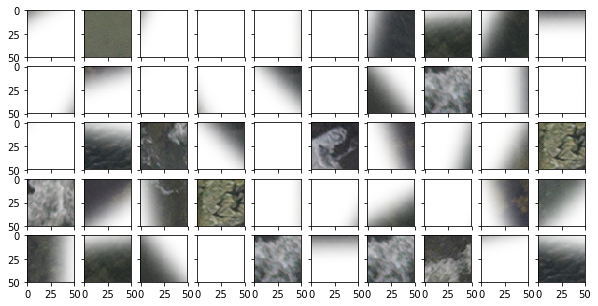

In [139]:
# randomly select from clusters and plot image
n = 50
label = 2

indices = np.random.choice(np.argwhere(prediction == label).flatten(), size=n)

fig, axes = plt.subplots(ncols=10,nrows=5, sharex=True, sharey=True, figsize=(10,5))
for ax, i in zip(axes.flat, indices):
    print(np.average(negative_patches[i]))
    ax.imshow(negative_patches[i])